In [58]:
import torch
import einops
from torchtyping import TensorType
from typing import Callable

In [63]:
# create synthetic data for superposition

NUM_MODELS = 10
INPUT_FEATURES = 40
HIDDEN_FEATURES = 5
NUM_DATA = 10_000
TRAIN_BATCH = 1

sparsity = torch.linspace(0.99, 0.01, NUM_MODELS)

random_dataset: TensorType[NUM_MODELS, NUM_DATA, INPUT_FEATURES] = \
    (torch.rand((NUM_MODELS, NUM_DATA, INPUT_FEATURES)) > sparsity[:, None, None]).float()
random_dataset = random_dataset.requires_grad_(False)

# Sanity Check

this section proves simple statistical fact that for each model inputs,
synthetic data produced based on the given sparsity $S$, the average appearance of $x_i = 1$ within length $n$ data will follow binomial distribution.

$$
\begin{align}
D_k \space = \space \{sequencs \space of \space x_i \space where \space x_i \space appears \space k \space times\} \\
P(D_k) \space = \space \binom{n}{k} (1-S)^k S^{n-k} \space = \space \frac{n!}{k!(n-k)!} (1-S)^k S^{n-k}
\end{align}
$$

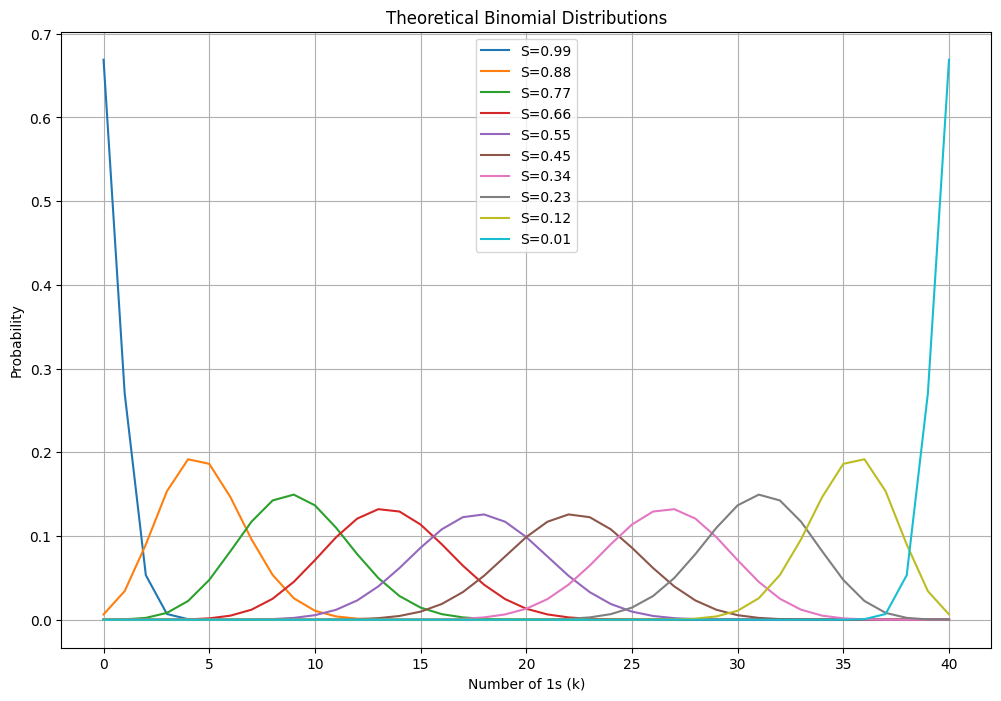

In [64]:
# Theoratical Binomial Distribution

def binomial(n, k):
    # Calculate binomial coefficient n choose k
    if k > n:
        return 0
    k = min(k, n-k)
    result = 1
    for i in range(k):
        result *= (n - i)
        result //= (i + 1)
    return result

k = torch.arange(INPUT_FEATURES + 1)
theoretical_dist = torch.zeros((NUM_MODELS, INPUT_FEATURES + 1))

for i in range(NUM_MODELS):
    S = sparsity[i]
    for j in range(INPUT_FEATURES + 1):
        theoretical_dist[i,j] = binomial(INPUT_FEATURES, j) * (1-S)**j * S**(INPUT_FEATURES-j)

# Plot the distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
for i in range(NUM_MODELS):
    plt.plot(k, theoretical_dist[i], label=f'S={sparsity[i]:.2f}')
plt.xlabel('Number of 1s (k)')
plt.ylabel('Probability')
plt.title('Theoretical Binomial Distributions')
plt.legend()
plt.grid(True)
plt.show()


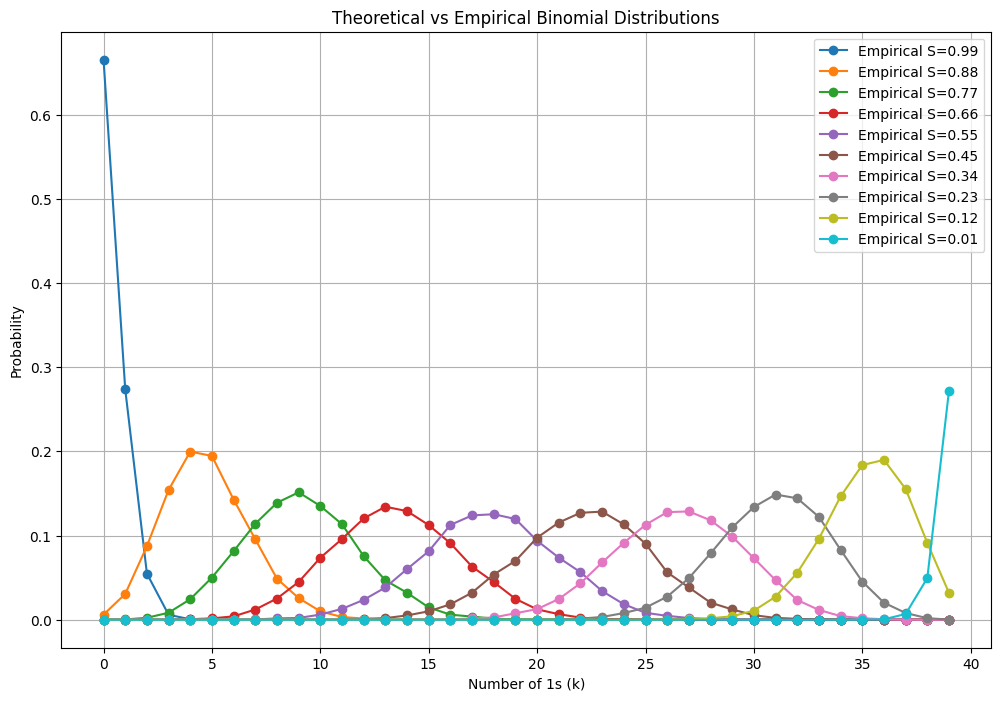

In [65]:
# Within dataset

# Calculate empirical distribution from random_dataset
empirical_dist = torch.zeros((NUM_MODELS, INPUT_FEATURES))

for i in range(NUM_MODELS):
    # Count occurrences of 1s in each sequence
    num_ones = torch.sum(random_dataset[i], dim=1)  # Sum across features for each data point
    
    # Calculate histogram/distribution
    for k in range(INPUT_FEATURES):
        # Count sequences with k ones and normalize by dataset size
        empirical_dist[i,k] = torch.sum(num_ones == k).float() / NUM_DATA

# Plot empirical distributions alongside theoretical
plt.figure(figsize=(12,8))
for i in range(NUM_MODELS):
    plt.plot(torch.arange(INPUT_FEATURES), empirical_dist[i], 'o-', label=f'Empirical S={sparsity[i]:.2f}')
plt.xlabel('Number of 1s (k)')
plt.ylabel('Probability')
plt.title('Theoretical vs Empirical Binomial Distributions')
plt.legend()
plt.grid(True)
plt.show()


In [66]:
# feature importance
importance = torch.linspace(0.99, 0.01, INPUT_FEATURES // 5)
importance = torch.repeat_interleave(importance, 5)

importance.requires_grad_(False)

tensor([0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.8500, 0.8500, 0.8500, 0.8500,
        0.8500, 0.7100, 0.7100, 0.7100, 0.7100, 0.7100, 0.5700, 0.5700, 0.5700,
        0.5700, 0.5700, 0.4300, 0.4300, 0.4300, 0.4300, 0.4300, 0.2900, 0.2900,
        0.2900, 0.2900, 0.2900, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100])

In [67]:
feature_weights: TensorType[NUM_MODELS, INPUT_FEATURES, HIDDEN_FEATURES] = \
    torch.randn((NUM_MODELS, INPUT_FEATURES, HIDDEN_FEATURES), requires_grad=True)

def forward(
    feature_weights: TensorType[NUM_MODELS, INPUT_FEATURES, HIDDEN_FEATURES], 
    input: TensorType[NUM_MODELS, TRAIN_BATCH, INPUT_FEATURES],
    activation: Callable[[TensorType[NUM_MODELS, TRAIN_BATCH, HIDDEN_FEATURES]], TensorType[NUM_MODELS, TRAIN_BATCH, HIDDEN_FEATURES]] | None = None,
) -> TensorType[NUM_MODELS, TRAIN_BATCH, HIDDEN_FEATURES]:
    hidden = einops.einsum(
        input,
        feature_weights,
        "m b i, m i h -> m b h",
    )
    reconstructed = einops.einsum(
        hidden,
        feature_weights.transpose(1, 2),
        "m b h, m h i -> m b i",
    )    
    return activation(reconstructed) if activation else reconstructed

def backward(
    output: TensorType[NUM_MODELS, TRAIN_BATCH, INPUT_FEATURES],
    target: TensorType[NUM_MODELS, TRAIN_BATCH, INPUT_FEATURES],
    importance: TensorType[INPUT_FEATURES],
    optimizer: torch.optim.Adam
) -> TensorType[1]:
    
    optimizer.zero_grad()
    # Broadcast importance to match output shape
    importance_broadcast = importance.view(1, 1, -1).expand_as(output)
    
    # this is because importance is multiplied outside of the loss for each features
    # but pytorch averages everything giving us no change to multiply the importance before averaging.
    # so we somehow force the importance unit inside the loss (note that importance is squared...)
    loss = torch.nn.functional.mse_loss(
        output * importance_broadcast ** 2, 
        target * importance_broadcast ** 2
    )
    loss.backward()
    optimizer.step()
    
    return loss

In [71]:
TRAIN_BATCH = 1

optimizer = torch.optim.Adam([feature_weights], lr=0.01)
for step in range(NUM_DATA):
    output = forward(feature_weights, random_dataset[:, step, :].unsqueeze(1))
    loss = backward(output, random_dataset[:, step, :].unsqueeze(1), optimizer)
    
    if step % 100 == 0:
        print(f"Step {step} loss: {loss.item()}")

TypeError: backward() missing 1 required positional argument: 'optimizer'